In [3]:
DO_TRAINING = True
EPOCHS_TO_TRAIN = 5
BASE_MODEL = "google/vit-base-patch16-224"
OUTPUT_MODEL_DIR = "./vit-base-pcb"

Resolving data files: 100%|██████████| 312/312 [00:00<00:00, 794067.26it/s]


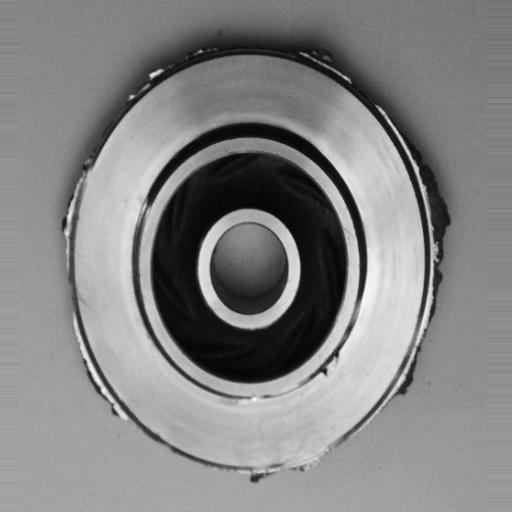

In [24]:
from datasets import load_dataset

dataset = load_dataset("dataset")
dataset["train"][0]["image"]

In [5]:
from transformers import ViTImageProcessor

model_name = BASE_MODEL if DO_TRAINING else OUTPUT_MODEL_DIR
processor = ViTImageProcessor.from_pretrained(model_name)
# processor(dataset["train"][-1]["image"], return_tensors="pt")

In [6]:
def transform(batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = batch['label']
    return inputs

prepared_ds = dataset.with_transform(transform)
# prepared_ds["train"][0]

In [7]:
import torch


def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": torch.tensor([x["label"] for x in batch]),
    }

In [8]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/var/folders/pj/7067lzld26jcb7f73tlb3y1w0000gn/T/ipykernel_92630/2425197347.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [9]:
from transformers import ViTForImageClassification

labels = dataset['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True
)


In [10]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=OUTPUT_MODEL_DIR,
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=EPOCHS_TO_TRAIN,
  # fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [11]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=processor,
)

In [12]:
if DO_TRAINING:
    try:
        train_results = trainer.train(resume_from_checkpoint=True)
    except ValueError:
        train_results = trainer.train()
    trainer.save_model()
    trainer.log_metrics("train", train_results.metrics)
    trainer.save_metrics("train", train_results.metrics)
    trainer.save_state()

In [13]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

100%|██████████| 39/39 [00:15<00:00,  2.57it/s]

***** eval metrics *****
  eval_accuracy           =     0.9615
  eval_loss               =     0.1318
  eval_runtime            = 0:00:16.04
  eval_samples_per_second =     19.444
  eval_steps_per_second   =      2.431


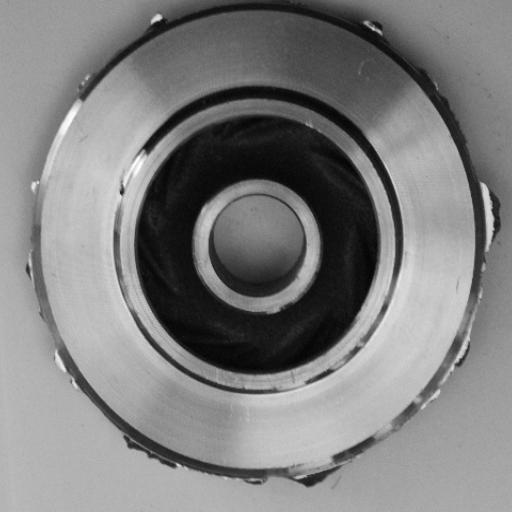

'defective'

In [23]:
from transformers import ViTImageProcessor, ViTForImageClassification

processor = ViTImageProcessor.from_pretrained(OUTPUT_MODEL_DIR)

model = ViTForImageClassification.from_pretrained(
    OUTPUT_MODEL_DIR,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True
)

image = dataset["test"][150]["image"]
inputs = processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item()
labels[predicted_label]

display(image, labels[predicted_label])